In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

## Load and Simple EDA

Information:

Trans_date_trans_time: Timestamp of the transaction (date and time).
Merchant: The merchant involved in the transaction. - Has quotes issues
Category Transaction type (e.g., personal, childcare).
Amt:Transaction amount.
City: Cardholder's city of residence.
State: Cardholder's state of residence.
Lat:Latitude of cardholder's location.
Long: Longitude of cardholder's location.
City_pop:Population of the cardholder's city.
Job:Cardholder's job title. -- Has quotes issues
Dob: Cardholder's date of birth.
Trans_num: Unique transaction identifier.
Merch_lat:Merchant's location (latitude).
Merch_long: Merchant's location (longitude).
Is_fraud:Fraudulent transaction indicator (1 = fraud, 0 = legitimate)

In [30]:
df = pd.read_csv("data/fraud_data.csv")

In [31]:
#Converting date and time features to numerical features, to avoid encontering issues with categorical encoders later on.

# Split the string into date and time parts
df['trans_date'] = df['trans_date_trans_time'].str[:10]  # First 10 chars: MM-DD-YYYY
df['trans_time'] = df['trans_date_trans_time'].str[11:16]  # Next 5 chars: HH:MM

# Ensure correct formats
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%d-%M-%Y', errors='coerce')
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M', errors='coerce')

# Extract features
df['trans_hour'] = df['trans_time'].dt.hour
df['trans_day'] = df['trans_date'].dt.day
df['trans_month'] = df['trans_date'].dt.month
df['trans_weekday'] = df['trans_date'].dt.weekday

# Drop intermediate columns if you want
df = df.drop(columns=['trans_date', 'trans_time', 'trans_date_trans_time'])

In [32]:
df.head()

,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,trans_hour,trans_day,trans_month,trans_weekday
0,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,0,4,1,4
1,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,15,4,1,4
2,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,22,4,1,4
3,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,23,4,1,4
4,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,23,4,1,4


In [33]:
#Checking Data Types
#is_fraud as a object is strange, since it is the target column with 0 and 1 values
df.dtypes

merchant          object
category          object
amt              float64
city              object
state             object
lat              float64
long             float64
city_pop           int64
job               object
dob               object
trans_num         object
merch_lat        float64
merch_long       float64
is_fraud          object
trans_hour         int32
trans_day          int32
trans_month        int32
trans_weekday      int32
dtype: object

In [34]:
#Descriptive Statistics about numeric columns

df.describe()

,amt,lat,long,city_pop,merch_lat,merch_long,trans_hour,trans_day,trans_month,trans_weekday
count,14446.000000,14446.000000,14446.000000,1.444600e+04,14446.000000,14446.000000,14446.000000,14446.000000,14446.0,14446.000000
mean,124.430073,39.787692,-110.874225,1.065370e+05,39.787991,-110.874892,13.034681,18.625294,1.0,2.745604
std,231.352587,5.317039,12.985813,2.902916e+05,5.360593,12.995596,7.290632,9.557553,0.0,2.056625
min,1.000000,20.027100,-165.672300,4.600000e+01,19.032689,-166.670685,0.000000,1.000000,1.0,0.000000
25%,12.080000,36.715400,-120.415800,4.930000e+02,36.794655,-120.146253,7.000000,10.000000,1.0,1.000000
50%,51.520000,39.666200,-111.098500,1.645000e+03,39.620953,-111.192629,14.000000,20.000000,1.0,2.000000
75%,101.030000,41.940400,-101.136000,3.543900e+04,42.275740,-100.446822,20.000000,28.000000,1.0,5.000000
max,3261.470000,66.693300,-89.628700,2.383912e+06,67.510267,-88.646366,23.000000,31.000000,1.0,6.000000


In [35]:
#Checking missing values and duplicates and unique values
df.isnull().sum()

merchant         0
category         0
amt              0
city             0
state            0
lat              0
long             0
city_pop         0
job              0
dob              0
trans_num        0
merch_lat        0
merch_long       0
is_fraud         0
trans_hour       0
trans_day        0
trans_month      0
trans_weekday    0
dtype: int64

In [36]:
df.duplicated().sum()

np.int64(63)

In [37]:
#Is fraud is the target, it should be only 2 unique values, 4 is strange.
df.nunique()

merchant           693
category            14
amt               9266
city               176
state               13
lat                183
long               183
city_pop           174
job                163
dob                187
trans_num        14383
merch_lat        14376
merch_long       14380
is_fraud             4
trans_hour          24
trans_day           31
trans_month          1
trans_weekday        7
dtype: int64

In [38]:
#There are some trash values in the target column, we should delete then
df['is_fraud'].value_counts()   

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

In [39]:
df_cleaned = df[df['is_fraud'].isin(['0', '1'])]
df_cleaned['is_fraud'] = df_cleaned['is_fraud'].astype(int)

df_cleaned['is_fraud'].value_counts()  

C:\Users\bruno\AppData\Local\Temp\ipykernel_1896\19296395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['is_fraud'] = df_cleaned['is_fraud'].astype(int)


is_fraud
0    12600
1     1844
Name: count, dtype: int64

In [40]:
#Droping duplicates and checking value counts again
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.value_counts()

merchant                      category       amt    city       state  lat      long       city_pop  job                                dob         trans_num                         merch_lat  merch_long   is_fraud  trans_hour  trans_day  trans_month  trans_weekday
"Adams, Kovacek and Kuhlman"  grocery_net    16.73  Lowell     OR     43.9210  -122.7806  1420      Systems analyst                    11-11-1965  3366abea053c361df2e0e965854fa127  43.120671  -123.405410  1         2           12         1            5                1
                                             36.96  Meridian   ID     43.6498  -116.4306  84106     Intelligence analyst               11-02-1971  006b7b594a01e55565ae45ca2dfb4d9d  43.313413  -116.190044  0         7           30         1            3                1
                                             40.19  Orient     WA     48.8878  -118.2105  149       Special educational needs teacher  21-06-1978  9848d1322114d3bb57b18c6fe272f9c6  49.807705  -11

In [41]:
#Removing quotes from merchant and job columns, this will help in encoding later
df_cleaned['merchant'] = df_cleaned['merchant'].str.replace(r'"', '', regex=True)
df_cleaned['job'] = df_cleaned['job'].str.replace(r'"', '', regex=True)

In [42]:
#Checking if there are still quotes in merchant column
merchant_check = [i for i in df_cleaned['merchant'].unique() if '"' in str(i)]
merchant_check

[]

In [43]:
#Checking if there are still quotes in job column
merchant_check = [i for i in df_cleaned['job'].unique() if '"' in str(i)]
merchant_check

[]

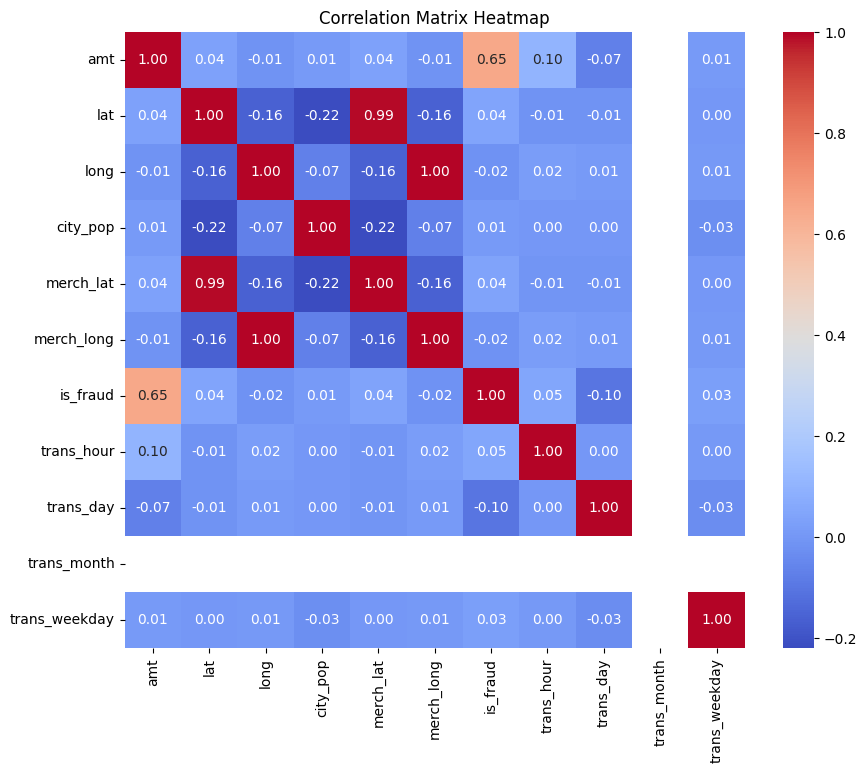

In [44]:
#Checking Correlation Matrix to drop highly correlated features
corr_matrix = df_cleaned.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [45]:
df_cleaned = df_cleaned.drop(columns=['merch_long', 'merch_lat','trans_num','dob'])

## Training

In [46]:
# 1. Balance the data (upsample minority class)
df_majority = df_cleaned[df_cleaned['is_fraud'] == 0]
df_minority = df_cleaned[df_cleaned['is_fraud'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])


In [47]:
df_balanced['is_fraud'].value_counts()

is_fraud
0    12600
1    12600
Name: count, dtype: int64

In [48]:
# Split features and target
X = df_balanced.drop('is_fraud', axis=1)
y = df_balanced['is_fraud']

# Identify categorical columns
categorical_cols = ['merchant', 'category', 'city', 'state','job']
numerical_cols = ['amt', 'lat', 'long','city_pop','trans_hour','trans_day','trans_month','trans_weekday']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [49]:
# Build pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Grid search for best hyperparameters (optimize for AUC)
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


In [50]:
grid.fit(X_train, y_train)

# 7. Print metrics
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

print("Best parameters:", grid.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best parameters: {'clf__C': 10, 'clf__penalty': 'l1'}
AUC: 0.9626111740992694
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2520
           1       0.89      0.90      0.89      2520

    accuracy                           0.89      5040
   macro avg       0.89      0.89      0.89      5040
weighted avg       0.89      0.89      0.89      5040



In [67]:
X_test.head(2).iloc[-1:,].to_dict(orient='records')

[{'merchant': 'Kerluke-Abshire',
  'category': 'shopping_net',
  'amt': 999.84,
  'city': 'Eugene',
  'state': 'OR',
  'lat': 44.0385,
  'long': -123.0614,
  'city_pop': 191096,
  'job': 'Scientist, physiological',
  'trans_hour': 12,
  'trans_day': 26,
  'trans_month': 1,
  'trans_weekday': 5}]

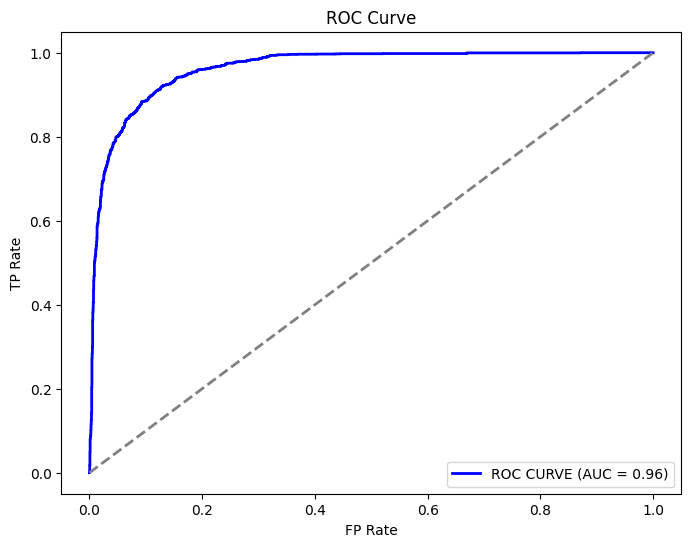

In [26]:
# Get predicted probabilities for the positive class
y_proba = grid.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC CURVE (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Saving the Artefact

In [28]:
# Saving the best model from GridSearchCV
joblib.dump(grid.best_estimator_, './artifacts/fraud_model.pkl')


['./artifacts/fraud_model.pkl']